In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Session 7 - data.zip to Session 7 - data.zip
User uploaded file "Session 7 - data.zip" with length 47297254 bytes


In [3]:
!unzip "Session 7 - data.zip"

Archive:  Session 7 - data.zip
replace data/hymenoptera_data/test/ants/1053149811_f62a3410d3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/hymenoptera_data/test/ants/1053149811_f62a3410d3.jpg  
  inflating: data/hymenoptera_data/test/ants/1073564163_225a64f170.jpg  
  inflating: data/hymenoptera_data/test/ants/1119630822_cd325ea21a.jpg  
  inflating: data/hymenoptera_data/test/ants/1124525276_816a07c17f.jpg  
  inflating: data/hymenoptera_data/test/ants/1247887232_edcb61246c.jpg  
  inflating: data/hymenoptera_data/test/ants/1262751255_c56c042b7b.jpg  
  inflating: data/hymenoptera_data/test/ants/1337725712_2eb53cd742.jpg  
 extracting: data/hymenoptera_data/test/ants/1358854066_5ad8015f7f.jpg  
  inflating: data/hymenoptera_data/test/ants/1440002809_b268d9a66a.jpg  
  inflating: data/hymenoptera_data/test/ants/1743840368_b5ccda82b7.jpg  
 extracting: data/hymenoptera_data/test/ants/2039585088_c6f47c592e.jpg  
  inflating: data/hymenoptera_data/test/ants/2104709400_883

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np

plt.ion()   # interactive mode

np.random.seed(1234)
torch.manual_seed(1234)

In [5]:
# Data Preprocessing
train_transform =  transforms.Compose([
        # image resizing + data augmentation
        transforms.RandomResizedCrop(224),         
        # data augmentation
        transforms.RandomHorizontalFlip(),         
        # convert image to PyTorch Tensor
        transforms.ToTensor(),    
        # z score normalization
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])

val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:
data_dir = 'data/hymenoptera_data'

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), val_test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)




In [10]:
# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:

class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.cc= nn.Conv2d(3,64,kernel_size=11,stride=2)

        self.cc1= nn.Conv2d(64,32,kernel_size=1)
        self.cc2= nn.Conv2d(32,128,kernel_size=5)
        self.cc3= nn.Conv2d(128,128,kernel_size=1)

        self.max= nn.MaxPool2d(kernel_size=3,stride=2)
        self.cca=nn.Conv2d(128,32, kernel_size=1)
        self.cct=nn.Conv2d(256,64, kernel_size=1)

        self.cc4= nn.Conv2d(128,64,kernel_size=1)
        
        self.cc5= nn.Conv2d(64,256,kernel_size=3)
        self.cc6= nn.Conv2d(256,256,kernel_size=1)
        self.avg= nn.AvgPool2d(kernel_size=2)
        self.fc = nn.Linear(112896, 2)

    def forward(self, X):
        X1 = self.cc(X)

        X2= self.cc1(X1)
        X3= self.cc2(X2)
        X4= self.cc3(X3)
        X1=X4

        X2= self.cca(X1)
        X3= self.cc2(X2)
        X4= self.cc3(X3)
        X1=X4
        
        max=self.max(X1)
        

        X2= self.cc4(max)
        X3= self.cc5(X2)
        X4= self.cc6(X3)
        X1=X4

        X2= self.cct(X1)
        X3= self.cc5(X2)
        X4= self.cc6(X3)
        X1=X4

        X2= self.cct(X1)
        X3= self.cc5(X2)
        X4= self.cc6(X3)
        X1=X4

        X = self.avg(X1)
        X = torch.flatten(X, 1)
        X = self.fc(X)
        return X

In [19]:
net = Net()


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [21]:

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
epochs = 2
 
train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf

for i in range(epochs):  
    #===============================================================
    # training 
    train_losses = []
    
    print("=========================================================")
    print("Epoch {}".format(i))
    
    for iteration, batch_data in enumerate(train_loader):
        X_batch, y_batch = batch_data
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        out = net(X_batch)
        loss = criterion(out, y_batch.squeeze())
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss)
    
    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))
    
    train_mean_losses.append(train_mean_loss)
    
    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            X_batch, y_batch = batch_data
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            out = net(X_batch)
            loss = criterion(out, y_batch.squeeze())
            valid_losses.append(loss)
            
        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))
        
        valid_mean_losses.append(valid_mean_loss)
        
        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================
    
    scheduler.step()

Epoch 0
training loss: 0.71408165
validation loss: 0.69220644
Epoch 1
training loss: 0.70438355
validation loss: 0.69626617


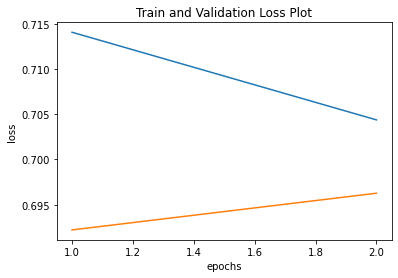

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(1,epochs+1), train_mean_losses)
plt.plot(range(1,epochs+1), valid_mean_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()

In [25]:
net.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [26]:
test_predictions = np.empty((0,2))
test_gt = np.empty((2))
with torch.no_grad():
    for iteration, batch_data in enumerate(test_loader):
        X_batch, y_batch = batch_data        
        out = net(X_batch)
        
        test_predictions = np.append(test_predictions, out.numpy(), 
                                     axis=0)
        test_gt = np.append(test_gt, y_batch, 
                                     axis=0)
        

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

test_predictions = np.array(test_predictions)
test_predictions = np.argmax(np.array(test_predictions), axis=1)

print("=========================================================\n")
print("Predicted Class:")
print(test_predictions)
print("\nGround Truth:")
print(test_gt)

print("\n=========================================================\n")
print("Confusion Matrix:")
print(confusion_matrix(test_gt, test_predictions))

print("\n=========================================================\n")
accuracy = accuracy_score(test_gt, test_predictions)
print("Accuracy: {}".format(accuracy))

f1 = f1_score(test_gt, test_predictions, average='macro')
print("F1 Score: ", f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(test_gt, test_predictions))


Predicted Class:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]

Ground Truth:
[0.5 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1. ]


Confusion Matrix:


ValueError: ignored

In [ ]:
import struct
import numpy as np
from scipy import signal as sg

sampling_rate = 44100                    ## Sampling Rate
freq = 440                               ## Frequency (in Hz)
samples = 44100                          ## Number of samples 
x = np.arange(samples)

####### sine wave ###########
y = 100*np.sin(2 * np.pi * freq * x / sampling_rate)

####### square wave ##########
# y = 100* sg.square(2 *np.pi * f *x / Fs )

####### square wave with Duty Cycle ##########
# y = 100* sg.square(2 *np.pi * f *x / Fs , duty = 0.8)

####### Sawtooth wave ########
# y = 100* sg.sawtooth(2 *np.pi * f *x / Fs )


f = open('test.wav','wb')
## Instructions to play test.wav on computer
## 1. Open as Signed 8-bit on Audacity - Watch Video at https://bit.ly/2YwmN9q for instructions
## 2. Or using SoX: play -t raw -r 44.1k -e signed -b 8 -c 1 test.wav

for i in y:
	f.write(struct.pack('b',int(i)))
f.close()

source https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
